# **Lesson 05**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [21]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params

In quantum physics a **wave function**, $\Psi$, is a mathematical description of the state of a quantum system. The wave function is a complex-valued probability amplitude, and the probabilities for the possible results of measurements made on the system can be derived from it.

For now on, let's consider the simple case of a non-relativistic single particle, without spin, in three spatial dimensions. The state of such a particle is completely described by its wave function, $\Psi(\vec{r},t)$, where $\vec{r}$ is position and $t$ is time.

For one spinless particle, if the wave function is interpreted as a probability amplitude, the square modulus of the wave function, $|\Psi(\vec{r},t)|^2$, is interpreted as the probability density that the particle is at $\vec{r}$ at time $t$. Once we have a probability density, we can use Monte Carlo ...

#### Hydrogen atom
The wave functions of the eigenstates of an electron in a Hydrogen atom (this is the only atom for which the Schroedinger equation has been solved exactly) are expressed in terms of spherical harmonics and generalized Laguerre polynomials. It is convenient to use spherical coordinates, and the wave function can be separated into functions of each coordinate:

$$
\Psi_{n,l,m}(r,\theta,\phi)=
\sqrt{\left(\frac{2}{na_0}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]}}
e^{-r/na_0}\left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\left(\frac{2r}{na_0}\right)
Y_l^m(\theta,\phi)
$$

where $a_0=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ nm is the Bohr radius, $L_{n-l-1}^{2l+1}$ are the generalized Laguerre polynomials of degree $n-l-1$, $n=1,2,...$ is the principal quantum number, $l=0,1, ..., n-1$ the azimuthal quantum number, $m=-l, -l+1, ..., l-1, l$ the magnetic quantum number.

For example, the ground state wave function is:
$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
whereas one of the three $2p$ excited state is:
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$
Expectation values for the radius turns out to be exactly:
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$

# Exercise 05.1

Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.

Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.

- Use Bohr radius units, $a_0$ for distances
- Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- How large should be the number of Monte Carlo Metropolis steps in each block?
- If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?

## Solution

### Metropolis algorithm

In order to sample a generic (known) density probability, the **Metropolis** (or $M(RT)^2$) **algorithm** turns out to be a very useful tool. This algorithm relies on an accept-reject loop ad needs only to know the expression of the target probability density $p(x)$.

The $M(RT)^2$ algorithm can be summed up in two main stages:
- **Propose** a step, according to a trial transition probability $T(x_{i+1}|x_i)$. The length of this step is called $\delta$, and its maximum value $\Delta$ is an important parameter that should be fixed appropriately.
- **Accept** the proposed step with an acceptance probability given by: 

    $$ A(x_{i+1}|x_i) = \min \left[ 1 \, , \frac{p(x_{i+1})}{p(x_i)}  \right] \ , $$
    
    where in the case of this exercise $p(x) = |\Psi(x,t)|^2$. The acceptance rule states that the proposed move is accepted with probability $1$ if the new point has a higher value of $p(x)$, and with probability $p(x_{i+1})/p(x_i)$ otherwise.

In this exercise the step length $\delta$ is drawn either from a uniform distribution in range $[-\Delta, \Delta)$ or alternatively $\delta \sim \mathcal N (0, \Delta)$. The maximum length $\Delta$ is chosen to have an acceptance rate of the steps around $50\%$: this empirical rule is important because if the steps are too wide there will be a higher rejection rate, making the algorithm inefficient. On the other end, if steps are too small there could be correlation between next points.

### Code

To implement the $M(RT)^2$ algorithm i built a class `Metropolis`, that evolves an `arma::vec x_` with two types of transition probability, uniform (`type_`$=0$) and gaussian (`type_`$=1$), and computes acceptance probability using a reference to an object `function`.

Here I show the code for methods `Propose()` and `Accept()`:

```c++
void Metropolis :: Propose() {
    if(type_ == 0)
        for(int i=0 ; i<dim_ ; i++) x_[i] += rnd_.Rannyu(-step_, step_);
    else if(type_ == 1)
        for(int i=0 ; i<dim_ ; i++) x_[i] += rnd_.Gauss(0, step_);
    else {
        fmt::print("ERROR! Unknown type of probability distribution for the proposed step!\n\n");
        exit(0);
    }
}


bool Metropolis :: Accept() {
    double alpha = std::min(1., prob_(x_)/prob_(xold_));
    double rand = rnd_.Rannyu();

    if(rand <= alpha) {
        xold_ = x_;
        return true;
    }
    else {
        x_ = xold_;
        return false;
    }
}
```

While to set the step length `step_` to have an acceptance rate of $50\%$ i used the method `SetAcceptance()`:

```c++
double Metropolis :: SetAcceptance(double target, double prec, double step, int nstep, std::ofstream* out) {
    
    int accepted, counter = 1;
    double corr = step;
    std::string output;

    do {
        accepted = 0;
        step_ = step;
        x_ = arma::zeros<arma::vec>(dim_);
        xold_ = x_;

        for(int j=0 ; j<nstep ; j++) {
            this->Propose();
            if(this->Accept()) accepted++;
        }
        acc_ = (double)accepted/nstep;
        if(out) {
            output = fmt::format("{}) Step: {:.5f}\tAcceptance: {:.3f}\n", counter, step, acc_);
            (*out) << output;
        }
        counter++;

        if(corr > prec) corr /= 2.;
        else corr = prec;

        if(acc_ < target - prec) step -= corr;
        else if(acc_ > target + prec) step += corr;

    } while((acc_ < target - prec) or (acc_ > target + prec));

    return step_;
}
```

Finally, to compute the blocking average on the distance from the origin, i implemented the class `BA_Metro`.

### Equilibration

To avoid measuring positions that would alter the correct radius measure, I performed the equilibration of the system with starting points $x_0 = \left( \frac{3}{2}a_0, 0, 0 \right)$ for the ground state $\Psi_{1,0,0}$, and $x_0 = ( 5a_0, 0, 0)$ for the excited state $\Psi_{2,1,0}$.

In [22]:
eq_100_unif = np.loadtxt('05.1/eq_100_unif.csv', delimiter=',', skiprows=1)
eq_100_gaus = np.loadtxt('05.1/eq_100_gaus.csv', delimiter=',', skiprows=1)

eq_210_unif = np.loadtxt('05.1/eq_210_unif.csv', delimiter=',', skiprows=1)
eq_210_gaus = np.loadtxt('05.1/eq_210_gaus.csv', delimiter=',', skiprows=1)

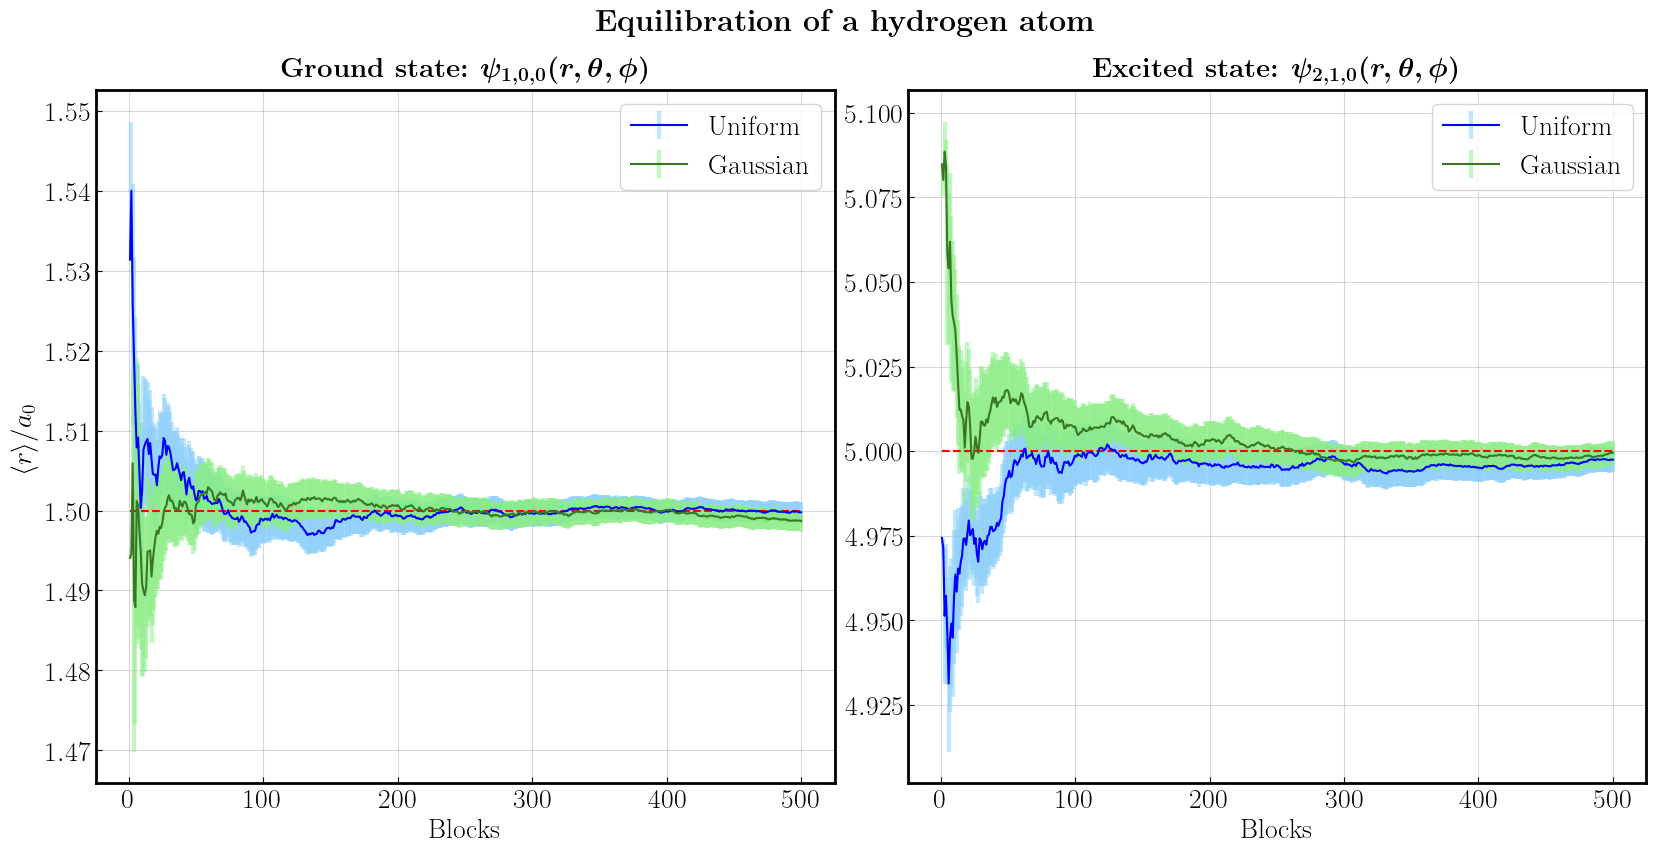

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,9), gridspec_kw={'wspace': 0.1})


line, caplines, barlinecols = axs[0].errorbar(eq_100_unif[:,0], eq_100_unif[:,2], yerr=eq_100_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[0].errorbar(eq_100_gaus[:,0], eq_100_gaus[:,2], yerr=eq_100_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_100 = np.ones(eq_100_unif.shape[0]) * 1.5
axs[0].plot(eq_100_unif[:,0], exact_100, color='red', linestyle='--')

axs[0].set_title(r'\textbf{Ground state:} \boldmath$\psi_{1,0,0}(r, \theta, \phi)$', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle r \rangle/a_0$', labelpad=6)
axs[0].legend()


line, caplines, barlinecols = axs[1].errorbar(eq_210_unif[:,0], eq_210_unif[:,2], yerr=eq_210_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[1].errorbar(eq_210_gaus[:,0], eq_210_gaus[:,2], yerr=eq_210_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_210 = np.ones(eq_210_unif.shape[0]) * 5
axs[1].plot(eq_210_unif[:,0], exact_210, color='red', linestyle='--')

axs[1].set_title(r'\textbf{Excited state:} \boldmath$\psi_{2,1,0}(r, \theta, \phi)$', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


fig.suptitle(r'\textbf{Equilibration of a hydrogen atom}', y=0.97, fontsize=22)

plt.show()

From this plots it is clear that after $300$ blocks the algorithm has converged.

**Plot parameters**:
- Extractions: $10^7$
- Blocks: $500$
- Extractions in each block: $2\times10^4$

### Measure

In [24]:
radius_100_unif = np.loadtxt('05.1/radius_100_unif.csv', delimiter=',', skiprows=1)
radius_100_gaus = np.loadtxt('05.1/radius_100_gaus.csv', delimiter=',', skiprows=1)

radius_210_unif = np.loadtxt('05.1/radius_210_unif.csv', delimiter=',', skiprows=1)
radius_210_gaus = np.loadtxt('05.1/radius_210_gaus.csv', delimiter=',', skiprows=1)

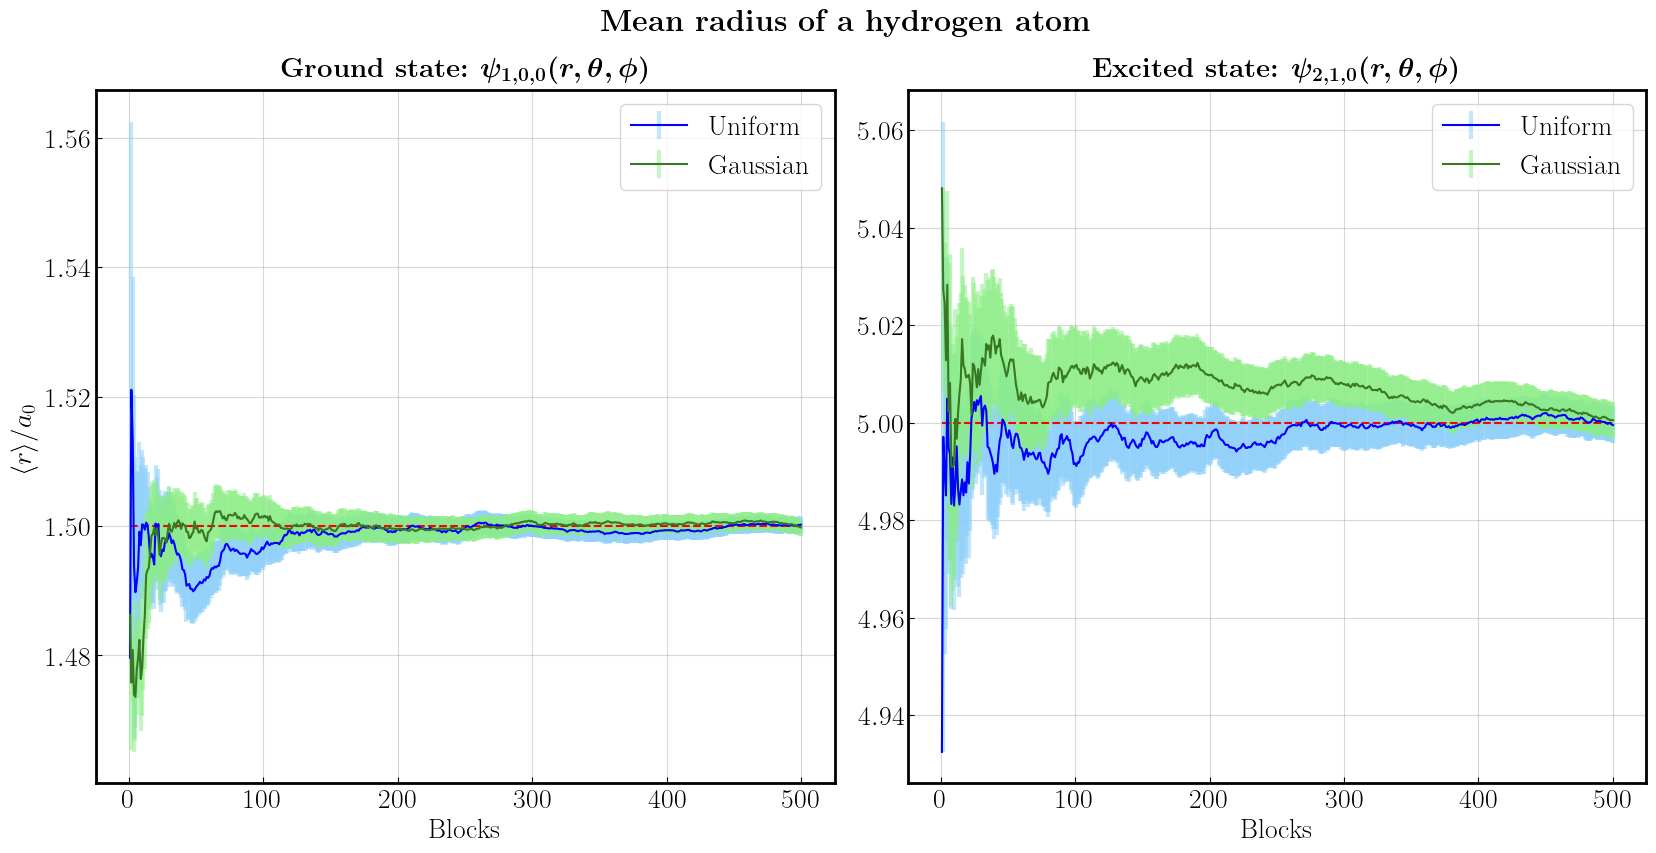

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20,9), gridspec_kw={'wspace': 0.1})


line, caplines, barlinecols = axs[0].errorbar(radius_100_unif[:,0], radius_100_unif[:,2], yerr=radius_100_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[0].errorbar(radius_100_gaus[:,0], radius_100_gaus[:,2], yerr=radius_100_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_100 = np.ones(radius_100_unif.shape[0]) * 1.5
axs[0].plot(radius_100_unif[:,0], exact_100, color='red', linestyle='--')

axs[0].set_title(r'\textbf{Ground state:} \boldmath$\psi_{1,0,0}(r, \theta, \phi)$', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle r \rangle/a_0$', labelpad=6)
axs[0].legend()


line, caplines, barlinecols = axs[1].errorbar(radius_210_unif[:,0], radius_210_unif[:,2], yerr=radius_210_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[1].errorbar(radius_210_gaus[:,0], radius_210_gaus[:,2], yerr=radius_210_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_210 = np.ones(radius_210_unif.shape[0]) * 5
axs[1].plot(radius_210_unif[:,0], exact_210, color='red', linestyle='--')

axs[1].set_title(r'\textbf{Excited state:} \boldmath$\psi_{2,1,0}(r, \theta, \phi)$', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


fig.suptitle(r'\textbf{Mean radius of a hydrogen atom}', y=0.97, fontsize=22)

plt.show()

This plots show the blocking average of the radius of the hydrogen atom (i.e. the mean electron distance from the origin) with their errors, in the case of the ground state (left) and of the first excited state (right). Both final values, sampled via a uniform or gaussian transition probabilities, are compatible within one $\sigma$ with the expectation values, that are $\frac{3}{2} a_0$ for the ground state and $5a_0$ for the excited state.

**Plot parameters**:
- Extractions: $10^7$
- Blocks: $500$
- Extractions in each block: $2\times10^4$

### Sampling

Below I show the obtained sampling of the wave functions performed using the Metropolis algorithm.

In [26]:
sampling_100_unif = np.loadtxt('05.1/sampling_100_unif.csv', delimiter=',', skiprows=1)
sampling_100_gaus = np.loadtxt('05.1/sampling_100_gaus.csv', delimiter=',', skiprows=1)

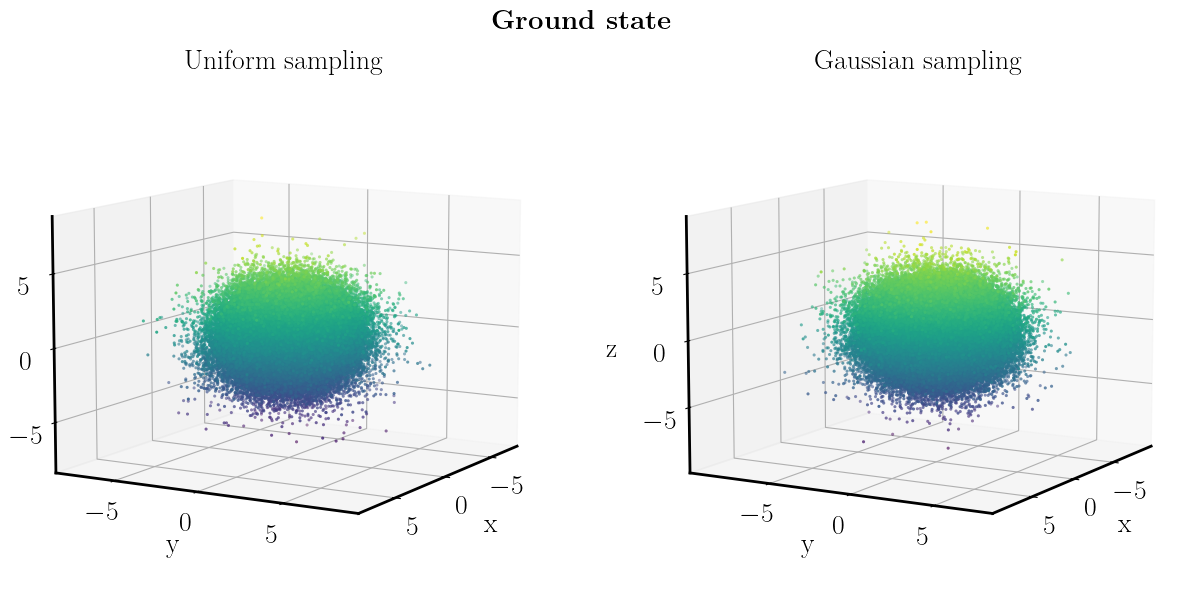

In [27]:
fig = plt.figure(figsize = (15,7))
fig.suptitle(r'\textbf{Ground state}', y=0.97, fontsize=20)
step = 10

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampling_100_unif[::step,0], sampling_100_unif[::step,1], sampling_100_unif[::step,2], marker='.', c=sampling_100_unif[::step,2], edgecolor='none')
ax.view_init(10, 30)

ax.set_title('Uniform sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampling_100_gaus[::step,0], sampling_100_gaus[::step,1], sampling_100_gaus[::step,2], marker='.', c=sampling_100_gaus[::step,2], edgecolor='none')
ax.view_init(10, 30)

ax.set_title('Gaussian sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()

The ground state $|\Psi_{1,0,0}|^2$ is spherically symmetric.

In [28]:
sampling_210_unif = np.loadtxt('05.1/sampling_210_unif.csv', delimiter=',', skiprows=1)
sampling_210_gaus = np.loadtxt('05.1/sampling_210_gaus.csv', delimiter=',', skiprows=1)

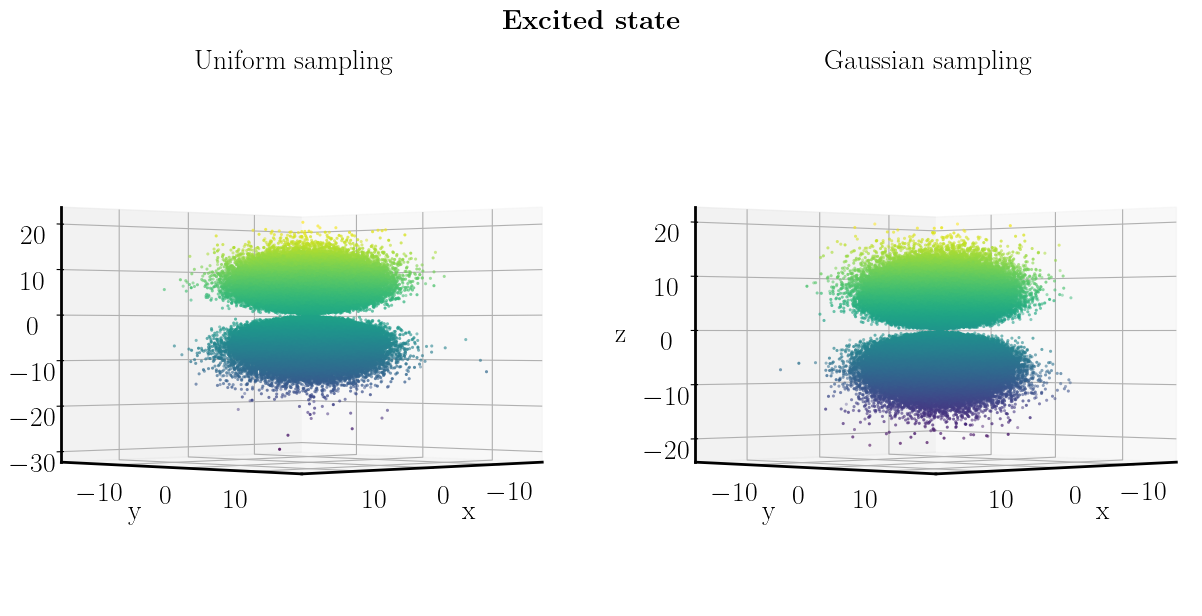

In [29]:
fig = plt.figure(figsize = (15,7))
fig.suptitle(r'\textbf{Excited state}', y=0.97, fontsize=20)
step = 10

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampling_210_unif[::step,0], sampling_210_unif[::step,1], sampling_210_unif[::step,2], marker='.', c=sampling_210_unif[::step,2], edgecolor='none')
ax.view_init(0, 45)

ax.set_title('Uniform sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampling_210_gaus[::step,0], sampling_210_gaus[::step,1], sampling_210_gaus[::step,2], marker='.', c=sampling_210_gaus[::step,2], edgecolor='none')
ax.view_init(0, 45)

ax.set_title('Gaussian sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()

The first excited state $|\Psi_{2,1,0}|^2$ has its characteristic form with two lobes and cylindrical symmetry.

### Equilibration far from the origin

Below I show the equilibration given a starting position very far from the origin: $x_0 = (100,100,100)a_0$. I used only uniform sampling for this part.

In [30]:
far_100_unif = np.loadtxt('05.1/far_100_unif.csv', delimiter=',', skiprows=1)
far_210_unif = np.loadtxt('05.1/far_210_unif.csv', delimiter=',', skiprows=1)

sampl_far_100_unif = np.loadtxt('05.1/sampl_far_100_unif.csv', delimiter=',', skiprows=1)
sampl_far_210_unif = np.loadtxt('05.1/sampl_far_210_unif.csv', delimiter=',', skiprows=1)

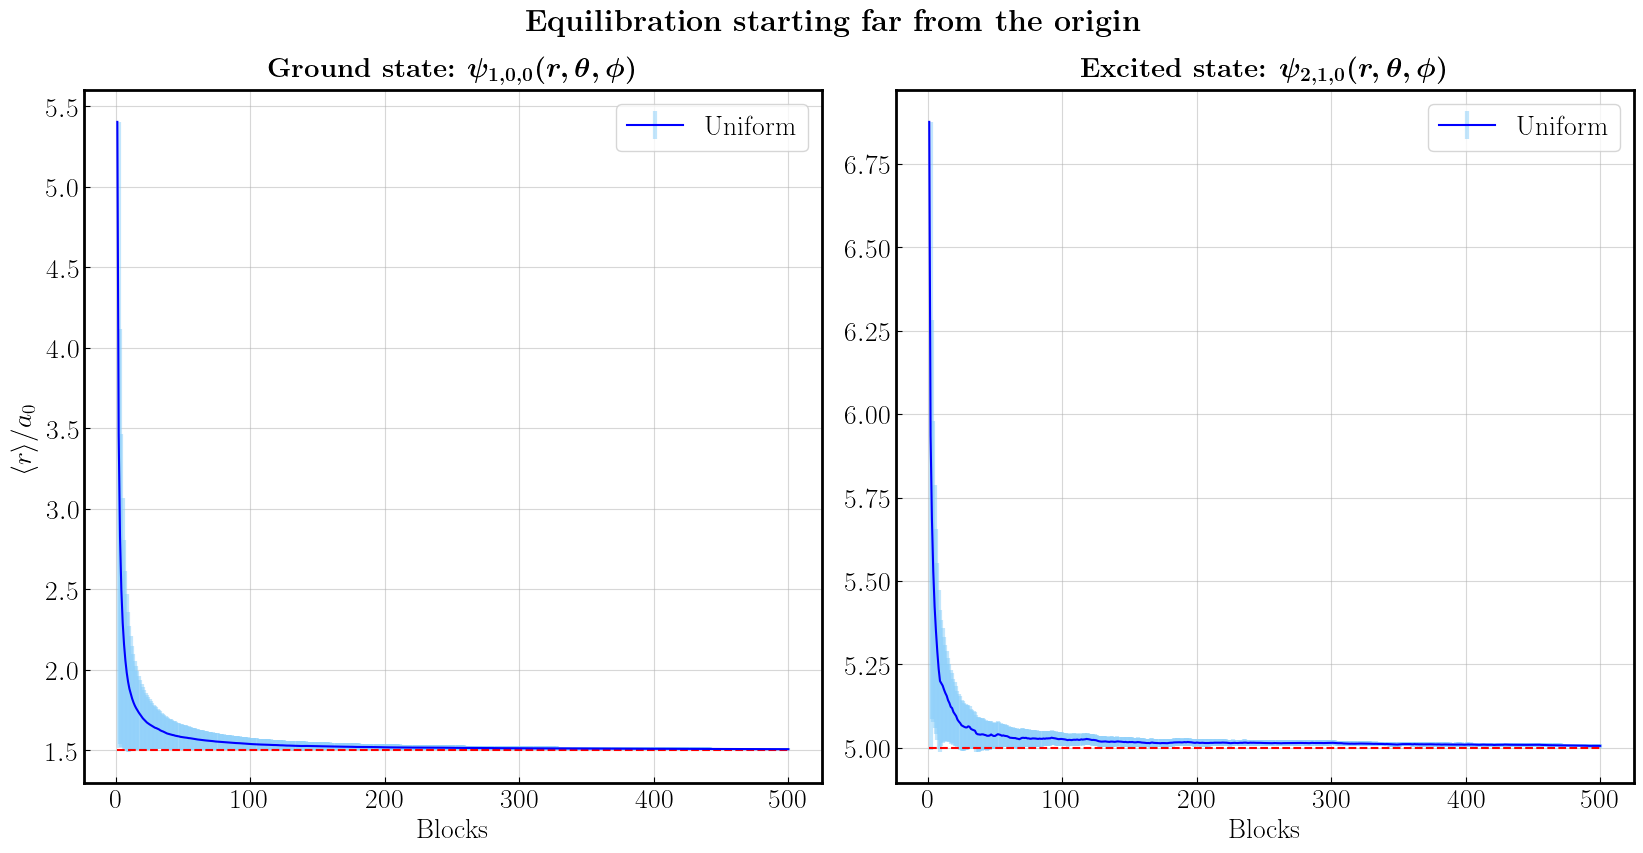

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20,9), gridspec_kw={'wspace': 0.1})


line, caplines, barlinecols = axs[0].errorbar(far_100_unif[:,0], far_100_unif[:,2], yerr=far_100_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
exact_100 = np.ones(far_100_unif.shape[0]) * 1.5
axs[0].plot(far_100_unif[:,0], exact_100, color='red', linestyle='--')

axs[0].set_title(r'\textbf{Ground state:} \boldmath$\psi_{1,0,0}(r, \theta, \phi)$', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle r \rangle/a_0$', labelpad=6)
axs[0].legend()


line, caplines, barlinecols = axs[1].errorbar(far_210_unif[:,0], far_210_unif[:,2], yerr=far_210_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
exact_210 = np.ones(far_210_unif.shape[0]) * 5
axs[1].plot(far_210_unif[:,0], exact_210, color='red', linestyle='--')

axs[1].set_title(r'\textbf{Excited state:} \boldmath$\psi_{2,1,0}(r, \theta, \phi)$', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


fig.suptitle(r'\textbf{Equilibration starting far from the origin}', y=0.97, fontsize=22)

plt.show()

We can note that, after approximately $300$ blocks the atom has reached its true shape.

**Plot parameters**:
- Extractions: $10^7$
- Blocks: $500$
- Extractions in each block: $2\times10^4$

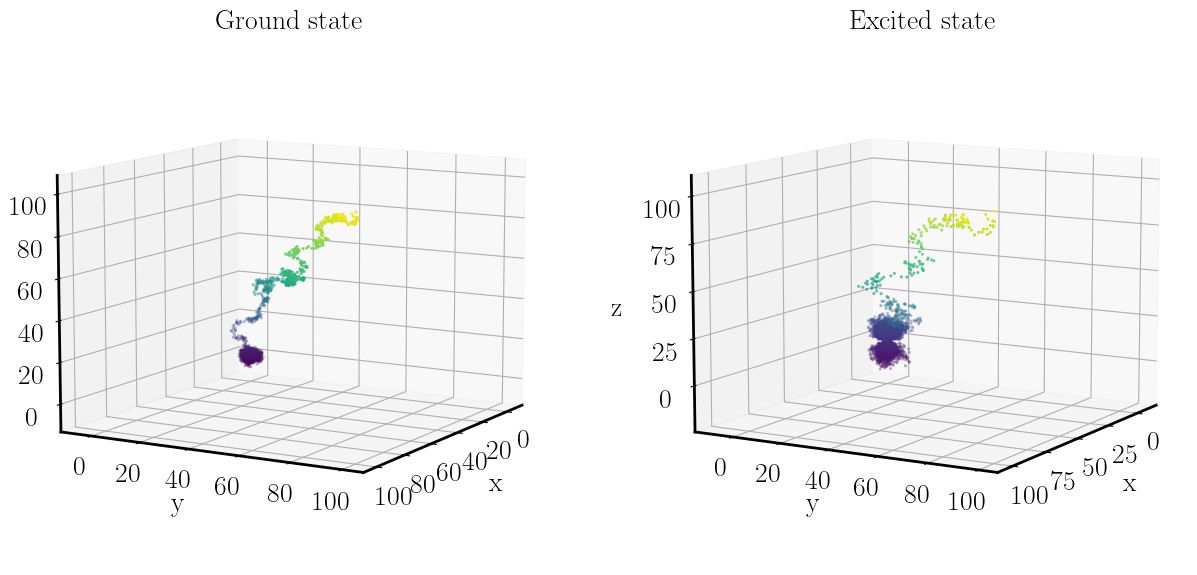

In [32]:
fig = plt.figure(figsize = (15,7))
max = int(1e4)
step = 1

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampl_far_100_unif[:max:step,0], sampl_far_100_unif[:max:step,1], sampl_far_100_unif[:max:step,2], marker='.', c=sampl_far_100_unif[:max:step,2], edgecolors='none')
ax.view_init(10, 30)

ax.set_title('Ground state')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampl_far_210_unif[:max:step,0], sampl_far_210_unif[:max:step,1], sampl_far_210_unif[:max:step,2], marker='.', c=sampl_far_210_unif[:max:step,2], edgecolors='none')
ax.view_init(10, 30)

ax.set_title('Excited state')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()

We can note that, thanks to $M(RT)^2$ algorithm, both the states converge to the correct shape of the hydrogen atom.